In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.utils
from sklearn.datasets import make_classification, load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

np.set_printoptions(threshold=5)  # to limit printing

from vflow import Vset, init_args, dict_to_df, perturbation_stats
from vflow.pipeline import build_graph

# Basic Pipeline

`vflow` allows us to easily construct a pipeline with several perturbations (e.g. different data subsamples, models, and metrics) by wrapping the set of functions at each stage in a `Vset`. We can then perform aggregate operations on our `Vset` (e.g. to fit all perturbations) and easily access downstream results. 

In [2]:
# initialize data
np.random.seed(13)
X, y = make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = init_args(
    (X_train, X_test, y_train, y_test),
    names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
)

# subsample data
subsampling_funcs = [
    partial(sklearn.utils.resample, n_samples=20, random_state=i)
    for i in range(3)
]
subsampling_set = Vset(name='subsampling',
                       vfuncs=subsampling_funcs,
                       output_matching=True)
X_trains, y_trains = subsampling_set(X_train, y_train)

# fit models
models = [LogisticRegression(max_iter=1000, tol=0.1), DecisionTreeClassifier()]
modeling_set = Vset(name='modeling',
                    vfuncs=models,
                    vfunc_keys=["LR", "DT"])

modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)

# get metrics
binary_metrics_set = Vset(name='binary_metrics',
                          vfuncs=[accuracy_score, balanced_accuracy_score],
                          vfunc_keys=["Acc", "Bal_Acc"])

binary_metrics = binary_metrics_set.evaluate(preds_test, y_test)

Our pipeline can be visualized from any stage using `build_graph(vset, draw=True)`:

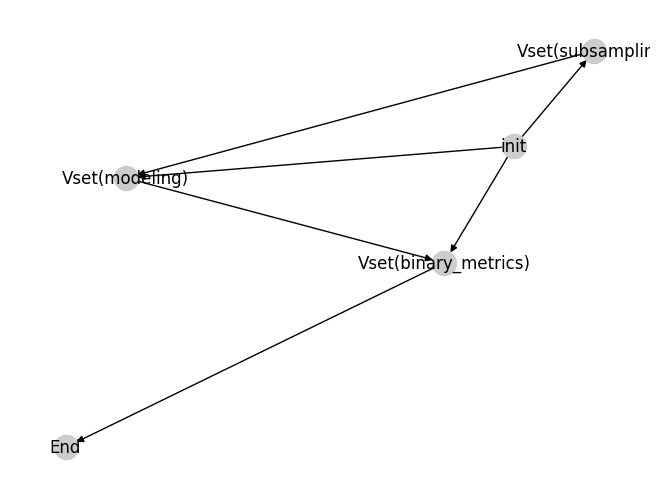

In [3]:
G = build_graph(binary_metrics, draw=True)
plt.show()

`Vset` outputs can be easily converted to pandas dataframes using `dict_to_df(out)`:

In [4]:
df = dict_to_df(binary_metrics)
df

/home/james/repos/Yu-Group/veridical-flow/vflow/utils.py:225: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(cols, axis=1, inplace=True)


,init-subsampling,init-subsampling,subsampling,init-modeling,modeling,init-binary_metrics,binary_metrics,out
0,X_test,X_train,subsampling_0,y_train,LR,y_test,Acc,0.923077
1,X_test,X_train,subsampling_1,y_train,LR,y_test,Acc,0.923077
2,X_test,X_train,subsampling_2,y_train,LR,y_test,Acc,0.846154
3,X_test,X_train,subsampling_0,y_train,DT,y_test,Acc,0.769231
4,X_test,X_train,subsampling_1,y_train,DT,y_test,Acc,0.846154
5,X_test,X_train,subsampling_2,y_train,DT,y_test,Acc,0.846154
6,X_test,X_train,subsampling_0,y_train,LR,y_test,Bal_Acc,0.944444
7,X_test,X_train,subsampling_1,y_train,LR,y_test,Bal_Acc,0.944444
8,X_test,X_train,subsampling_2,y_train,LR,y_test,Bal_Acc,0.837500
9,X_test,X_train,subsampling_0,y_train,DT,y_test,Bal_Acc,0.763889


We can then compute aggregate statistics on specified pipeline stages using `perturbations_stats(data, *group_by)`:

In [5]:
perturbation_stats(df, 'subsampling')

,subsampling,count,mean,std
0,subsampling_0,4,0.850160,0.096951
1,subsampling_1,4,0.903419,0.042271
2,subsampling_2,4,0.841827,0.004996


# Feature Engineering Pipeline

This `vflow` pipeline predicts disease progression using the diabetes dataset (regression).

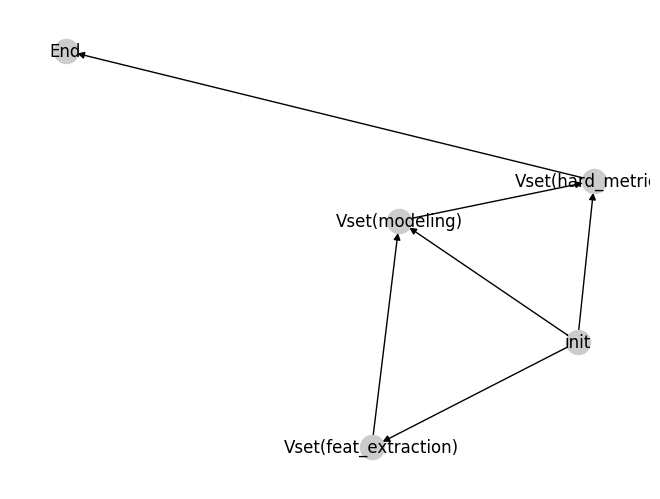

/home/james/repos/Yu-Group/veridical-flow/vflow/utils.py:225: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(cols, axis=1, inplace=True)


,init-feat_extraction,feat_extraction,init-modeling,init-modeling,modeling,init-hard_metrics,hard_metrics,out
0,X_train,feat_extraction_0,X_train,y_train,DT,y_train,r2,1.000000
1,X_train,feat_extraction_1,X_train,y_train,DT,y_train,r2,1.000000
2,X_train,feat_extraction_0,X_train,y_train,RF,y_train,r2,0.821769
3,X_train,feat_extraction_1,X_train,y_train,RF,y_train,r2,0.871953


In [6]:
# get data as df
np.random.seed(13)
data = load_diabetes()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = init_args(train_test_split(df, y, random_state=123),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])

# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['age', 'sex', 'bmi', 'bp']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]


feat_extraction_funcs = [partial(extract_feats, feat_names=['age', 'sex', 'bmi', 'bp']),
                         partial(extract_feats, feat_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']),
                         ]
feat_extraction = Vset(name='feat_extraction', vfuncs=feat_extraction_funcs, output_matching=True)

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

modeling_set = Vset(name='modeling',
                    vfuncs=[DecisionTreeRegressor(), RandomForestRegressor()],
                    vfunc_keys=["DT", "RF"])
modeling_set.fit(X_feats_train, y_train)

# get predictions
preds_all = modeling_set.predict(X_feats_train)

# get metrics
hard_metrics_set = Vset(name='hard_metrics',
                        vfuncs=[r2_score],
                        vfunc_keys=["r2"])
hard_metrics = hard_metrics_set.evaluate(preds_all, y_train)

# inspect the pipeline
G = build_graph(hard_metrics, draw=True)
plt.show()

df = dict_to_df(hard_metrics)
df